# Fanal, a neutrino-less beta decay experiment 

## An open exercise

### Signal Estimation from data - Fitting

#### USC, Master de Física, Física de Partículas II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz.

February 2021

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD your Fanal FOLDER TO PYTHONPATH
import os
import sys
import importlib
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Goal

  **Estimate the number of signal events in data. Estimate the half-life value**.

### Indications

   * Get the data
   
   * Estimate the number of signal events (with the method validated in the previous notebook)
   
   * Measure the half-life.
   
   * Estimate also the uncertainties.


## Main Parameters

In [5]:
coll   = 'test_alpha'
erange = (2.4, 2.7) #fn.erange
eroi   = fn.eroi 
eblob2 = fn.eblob2

print('Data From               : {:s}'.format(coll))
print('Energy range            : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Blob-2 energy threshold : {:6.3f} MeV'.format(eblob2))
print('Energy RoI range        : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Data From               : test_alpha
Energy range            : ( 2.400,  2.700) MeV
Blob-2 energy threshold :  0.400 MeV
Energy RoI range        : ( 2.430,  2.480) MeV


## Access the data

In [6]:
#dirpath = '/Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/'

In [7]:
filename = '/data/fanal_' + coll +'.h5'
print('Data : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

datab = pd.read_hdf(dirpath + filename, key = 'data/blind')
datar = pd.read_hdf(dirpath + filename, key = 'data/roi')
data  = pd.concat((datab, datar)) # concatenate blind and roi-data into one data DF

Data :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_test_alpha.h5


In [8]:
samples  = ['bb0nu', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$', r'$^{214}$Bi', r'$^{208}$Tl']
mcs      = [mcbb, mcbi, mctl]

## Estimate the number of events

In [9]:
from collpars import nevts_Bi, unevts_Bi
from collpars import nevts_Tl, unevts_Tl
nevts  = (10   , nevts_Bi , nevts_Tl)
unevts = (False, unevts_Bi, unevts_Tl)

selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 15
mc sizes             : [30217, 6688, 31607]
efficiencies         :   0.52, 1.76e-02, 7.28e-03
Initial       Events :   5.19,   2.60,   8.13
Uncertainties Events :   0.00,   0.32,   0.15
Fit success          :  True
Estimated     Events :   3.93,   2.58,   8.13


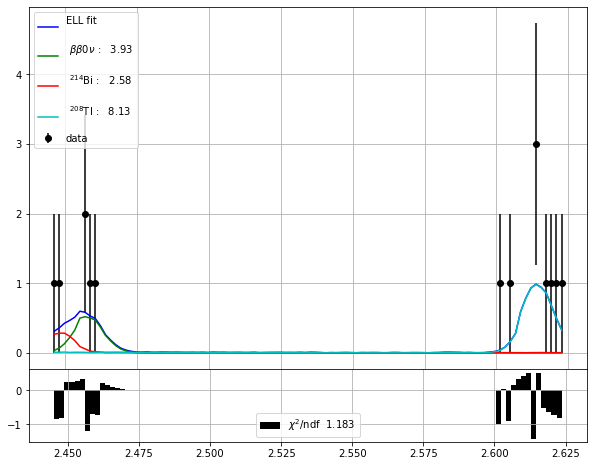

In [10]:
result, enes, ell, pdfs = fn.ana_experiment(data, mcs, nevts, unevts, bins = 180)
ns_est = result.x # number of estimated events

### Unconstrained Fit

Repeat the fit without the constraint in the number of background events

selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 15
mc sizes             : [30217, 6688, 31607]
efficiencies         :   0.52, 1.76e-02, 7.28e-03
Initial       Events :   5.19,   2.60,   8.13
Fit success          :  True
Estimated     Events :   4.13,   1.84,   9.03


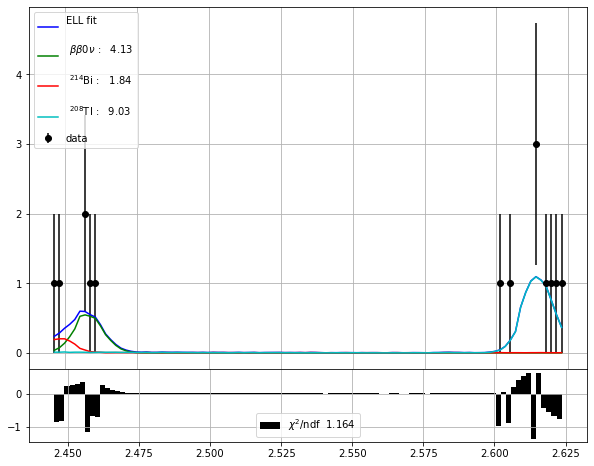

In [11]:
_ = fn.ana_experiment(data, mcs, nevts, bins = 180)

### Plot contributions

selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 15
mc sizes             : [30217, 6688, 31607]
efficiencies         :   0.52, 1.76e-02, 7.28e-03


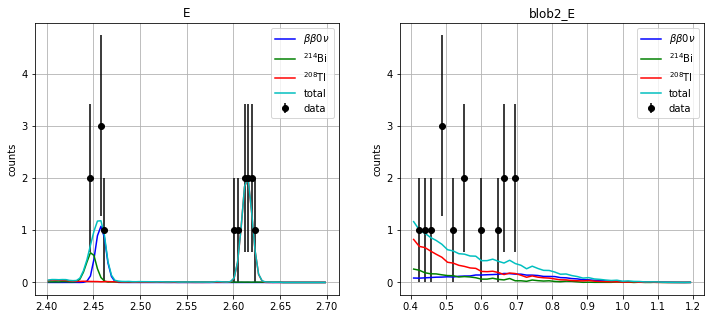

In [12]:
anadata, anamcs, effs = fn.ana_samples(data, mcs) 
subplot = pltext.canvas(2)
subplot(1); 
fn.plot_contributions(anadata, anamcs, ns_est)
subplot(2);
fn.plot_contributions(anadata, anamcs, ns_est, 'blob2_E', (0.4, 1.2), nbins = 50);

## Estime the half-life

In [13]:
eff_bb     = effs[0]
nevts_bb   = ns_est[0]
acc_bb     = collpars.acc_bb
exposure   = collpars.exposure
eff        = acc_bb * eff_bb
tau        = fn.half_life(nevts_bb, exposure, eff)

print('number of bb0nu events  : {:6.3f}'.format(nevts_bb))
print('exposure                : {:6.2f} kg y'.format(exposure))
print('total signal efficiency : {:6.3f}'.format(eff))
print('bb0nu half-life         : {:6.2e} y '.format(tau))
#TODO: uncertainties

number of bb0nu events  :  3.934
exposure                : 500.00 kg y
total signal efficiency :  0.412
bb0nu half-life         : 1.45e+26 y 


## Write Out

In [14]:
write = True

if (write):
    of = open('collpars.py', 'a')
    of.write('nevts_bb_fit    = {:6.3f}'.format(nevts_bb)+'\n')
    of.write('eff_bb_fit      = {:6.3f}'.format(eff_bb)+'\n')
    of.write('tau             = {:1.3e}'.format(tau)+' # y \n')
    of.close()